In [59]:
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

In [111]:
path_db = '../data/TUDataset'
dataset_tud = TUDataset(root=path_db, name='MUTAG')

In [112]:
data = dataset_tud[12]  # Get the first graph object.

In [114]:
type(dataset_tud)

torch_geometric.datasets.tu_dataset.TUDataset

In [38]:
data    # obtain dimensions 

Data(edge_index=[2, 50], x=[22, 7], edge_attr=[50, 4], y=[1])

In [54]:
data.edge_index.T         # obtain every undirected connections

tensor([[ 0,  1],
        [ 0,  5],
        [ 1,  0],
        [ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 3,  2],
        [ 3,  4],
        [ 3, 12],
        [ 4,  3],
        [ 4,  5],
        [ 4,  6],
        [ 5,  0],
        [ 5,  4],
        [ 6,  4],
        [ 6,  7],
        [ 6, 11],
        [ 7,  6],
        [ 7,  8],
        [ 8,  7],
        [ 8,  9],
        [ 9,  8],
        [ 9, 10],
        [ 9, 19],
        [10,  9],
        [10, 11],
        [10, 15],
        [11,  6],
        [11, 10],
        [11, 12],
        [12,  3],
        [12, 11],
        [12, 13],
        [13, 12],
        [13, 14],
        [14, 13],
        [14, 15],
        [14, 16],
        [15, 10],
        [15, 14],
        [16, 14],
        [16, 17],
        [16, 18],
        [17, 16],
        [18, 16],
        [19,  9],
        [19, 20],
        [19, 21],
        [20, 19],
        [21, 19]])

In [39]:
data.x    # obtain node labels

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]])

In [40]:
data.edge_attr       # obtain edges labels 

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1.,

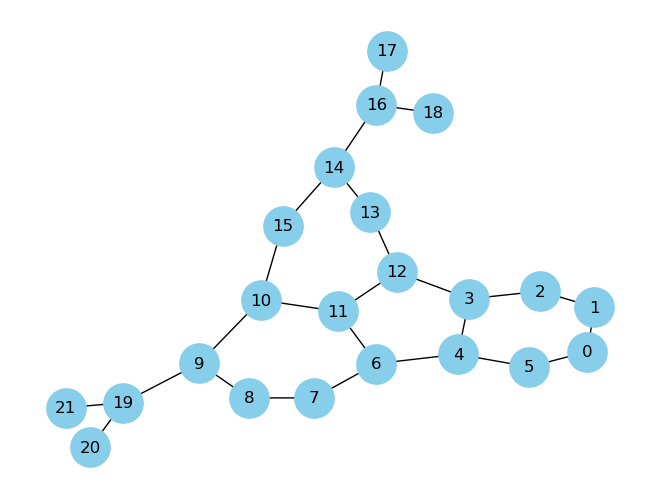

In [21]:
x = data.x.numpy()  # Assuming node features are stored in 'x'
edge_index = data.edge_index.numpy()  # Assuming edge information is in 'edge_index'
G = nx.Graph()

# Add nodes with features
for i in range(x.shape[0]):
    G.add_node(i, features=x[i])
# Add edges
for j in range(edge_index.shape[1]):
    G.add_edge(edge_index[0, j], edge_index[1, j])

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=800, cmap=plt.cm.Blues)
plt.show()

## HCP Data using Simeon preproc

In [135]:
def create_fc_matrices(scan, window_size=30, step_size=30):
    """
    Create functional connectivity matrices using a sliding window approach.
    """
    n_timepoints = scan.shape[1]
    fc_matrices = []

    for start in range(0, n_timepoints - window_size + 1, step_size):
        window = scan[:, start:start + window_size]
        correlation_matrix = np.corrcoef(window)
        fc_matrices.append(correlation_matrix)

    return fc_matrices


def threshold_fc_matrix(fc_matrix, percentile=5):
    """
    Threshold the FC matrix to keep only the top percentile connections.
    """
    threshold = np.percentile(fc_matrix[np.tril_indices_from(fc_matrix, k=-1)], 100 - percentile)   
    graph = (fc_matrix > threshold).astype(int)
    np.fill_diagonal(graph, 0)  # remove self-edges
    return graph


def create_networkx_graph(matrix):
    G = nx.Graph(matrix)
    return G


def convert_to_pyg_graph(nx_graph, label):
    graph = nx.Graph(nx_graph)
    edges = torch.tensor(list(graph.edges), dtype=torch.long).t().contiguous()
    x = torch.tensor(np.identity(graph.number_of_nodes()), dtype=torch.float)
    y = torch.tensor([label], dtype=torch.long)
    return Data(x=x, edge_index=edges, y=y)

In [138]:
data_path = '../data/hcp/raw'
dataset = []
for file_name in os.listdir(data_path):
    if file_name.endswith(".npy"):
        file_path = os.path.join(data_path, file_name)
        time_series_data = np.load(file_path)[:, :490]
        label = int(os.path.basename(file_path).split('_')[-1].split('.')[0])
        fc_matrices = create_fc_matrices(time_series_data)
        graphs = [threshold_fc_matrix(fc) for fc in fc_matrices] 
        pyg_graphs = []  
        for g in graphs: 
            pyg_graphs.append(convert_to_pyg_graph(g, label))
        dataset.append(pyg_graphs)

In [139]:
len(dataset)

300

In [140]:
torch.manual_seed(12345)
all_graphs = [graph for subject in dataset for graph in subject]
train_dataset = all_graphs[:4000]
test_dataset = all_graphs[4000:]
train_loader = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=30, shuffle=False)

In [141]:
data = next(iter(train_loader))

In [142]:
data

DataBatch(x=[10800, 360], edge_index=[2, 96930], y=[30], batch=[10800], ptr=[31])

In [ ]:
#TODO capire quali sono le input feature

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(360, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)

model = GCN(hidden_channels=64)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         # print(data.edge_index)
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader)  # Derive ratio of correct predictions.


for epoch in range(1, 50):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')